In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
# параметры распределений
mu0, cov0 = [-2., -2.], [[1., 0.], [0., 1.]]
mu1, cov1 = [3., 3.], [[2., 0.], [0., 2.]]

In [3]:
def sample(d0, d1, n=32):
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))
    y0 = torch.zeros((n, 1))
    y1 = torch.ones((n, 1))
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

In [4]:
d0 = torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor(mu0), torch.tensor(cov0))
d1 = torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor(mu1), torch.tensor(cov1))

In [5]:
layer = nn.Linear(2, 1)
print([p.data[0] for p in layer.parameters()])
layer_opt = optim.SGD(lr=1e-3, params=list(layer.parameters()))

[tensor([-0.6214,  0.5209]), tensor(-0.0354)]


In [6]:
log_freq = 500
for i in range(10000):
    if i%log_freq == 0:
        with torch.no_grad():
            x, y = sample(d0, d1, 100000)
            loss = F.binary_cross_entropy_with_logits(layer(x), y)
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    layer_opt.zero_grad()
    x, y = sample(d0, d1, 1024)
    loss = F.binary_cross_entropy_with_logits(layer(x), y)
    loss.backward()

    layer_opt.step()

Ошибка после 0 итераций: 0.936478
Ошибка после 1 итераций: 0.249192
Ошибка после 2 итераций: 0.143805
Ошибка после 3 итераций: 0.103442
Ошибка после 4 итераций: 0.083363
Ошибка после 5 итераций: 0.070674
Ошибка после 6 итераций: 0.061368
Ошибка после 7 итераций: 0.054741
Ошибка после 8 итераций: 0.049689
Ошибка после 9 итераций: 0.046033
Ошибка после 10 итераций: 0.042467
Ошибка после 11 итераций: 0.040148
Ошибка после 12 итераций: 0.037450
Ошибка после 13 итераций: 0.035221
Ошибка после 14 итераций: 0.033523
Ошибка после 15 итераций: 0.032090
Ошибка после 16 итераций: 0.030721
Ошибка после 17 итераций: 0.029790
Ошибка после 18 итераций: 0.028285
Ошибка после 19 итераций: 0.027506


In [7]:
x_scale = np.linspace(-10,10, 200)
y_scale = np.linspace(-10,10, 200)
X, Y = np.meshgrid(x_scale, y_scale)
pos = np.empty (X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
d0_pdf = stats.multivariate_normal.pdf(pos, mu0, cov0)
d1_pdf = stats.multivariate_normal.pdf(pos, mu1, cov1)
x_tensor = torch.tensor(pos.reshape(-1, 2), dtype=torch.float)
with torch.no_grad():
    dist = torch.sigmoid(layer(x_tensor)).numpy()

ratio = d1_pdf / (d1_pdf + d0_pdf)

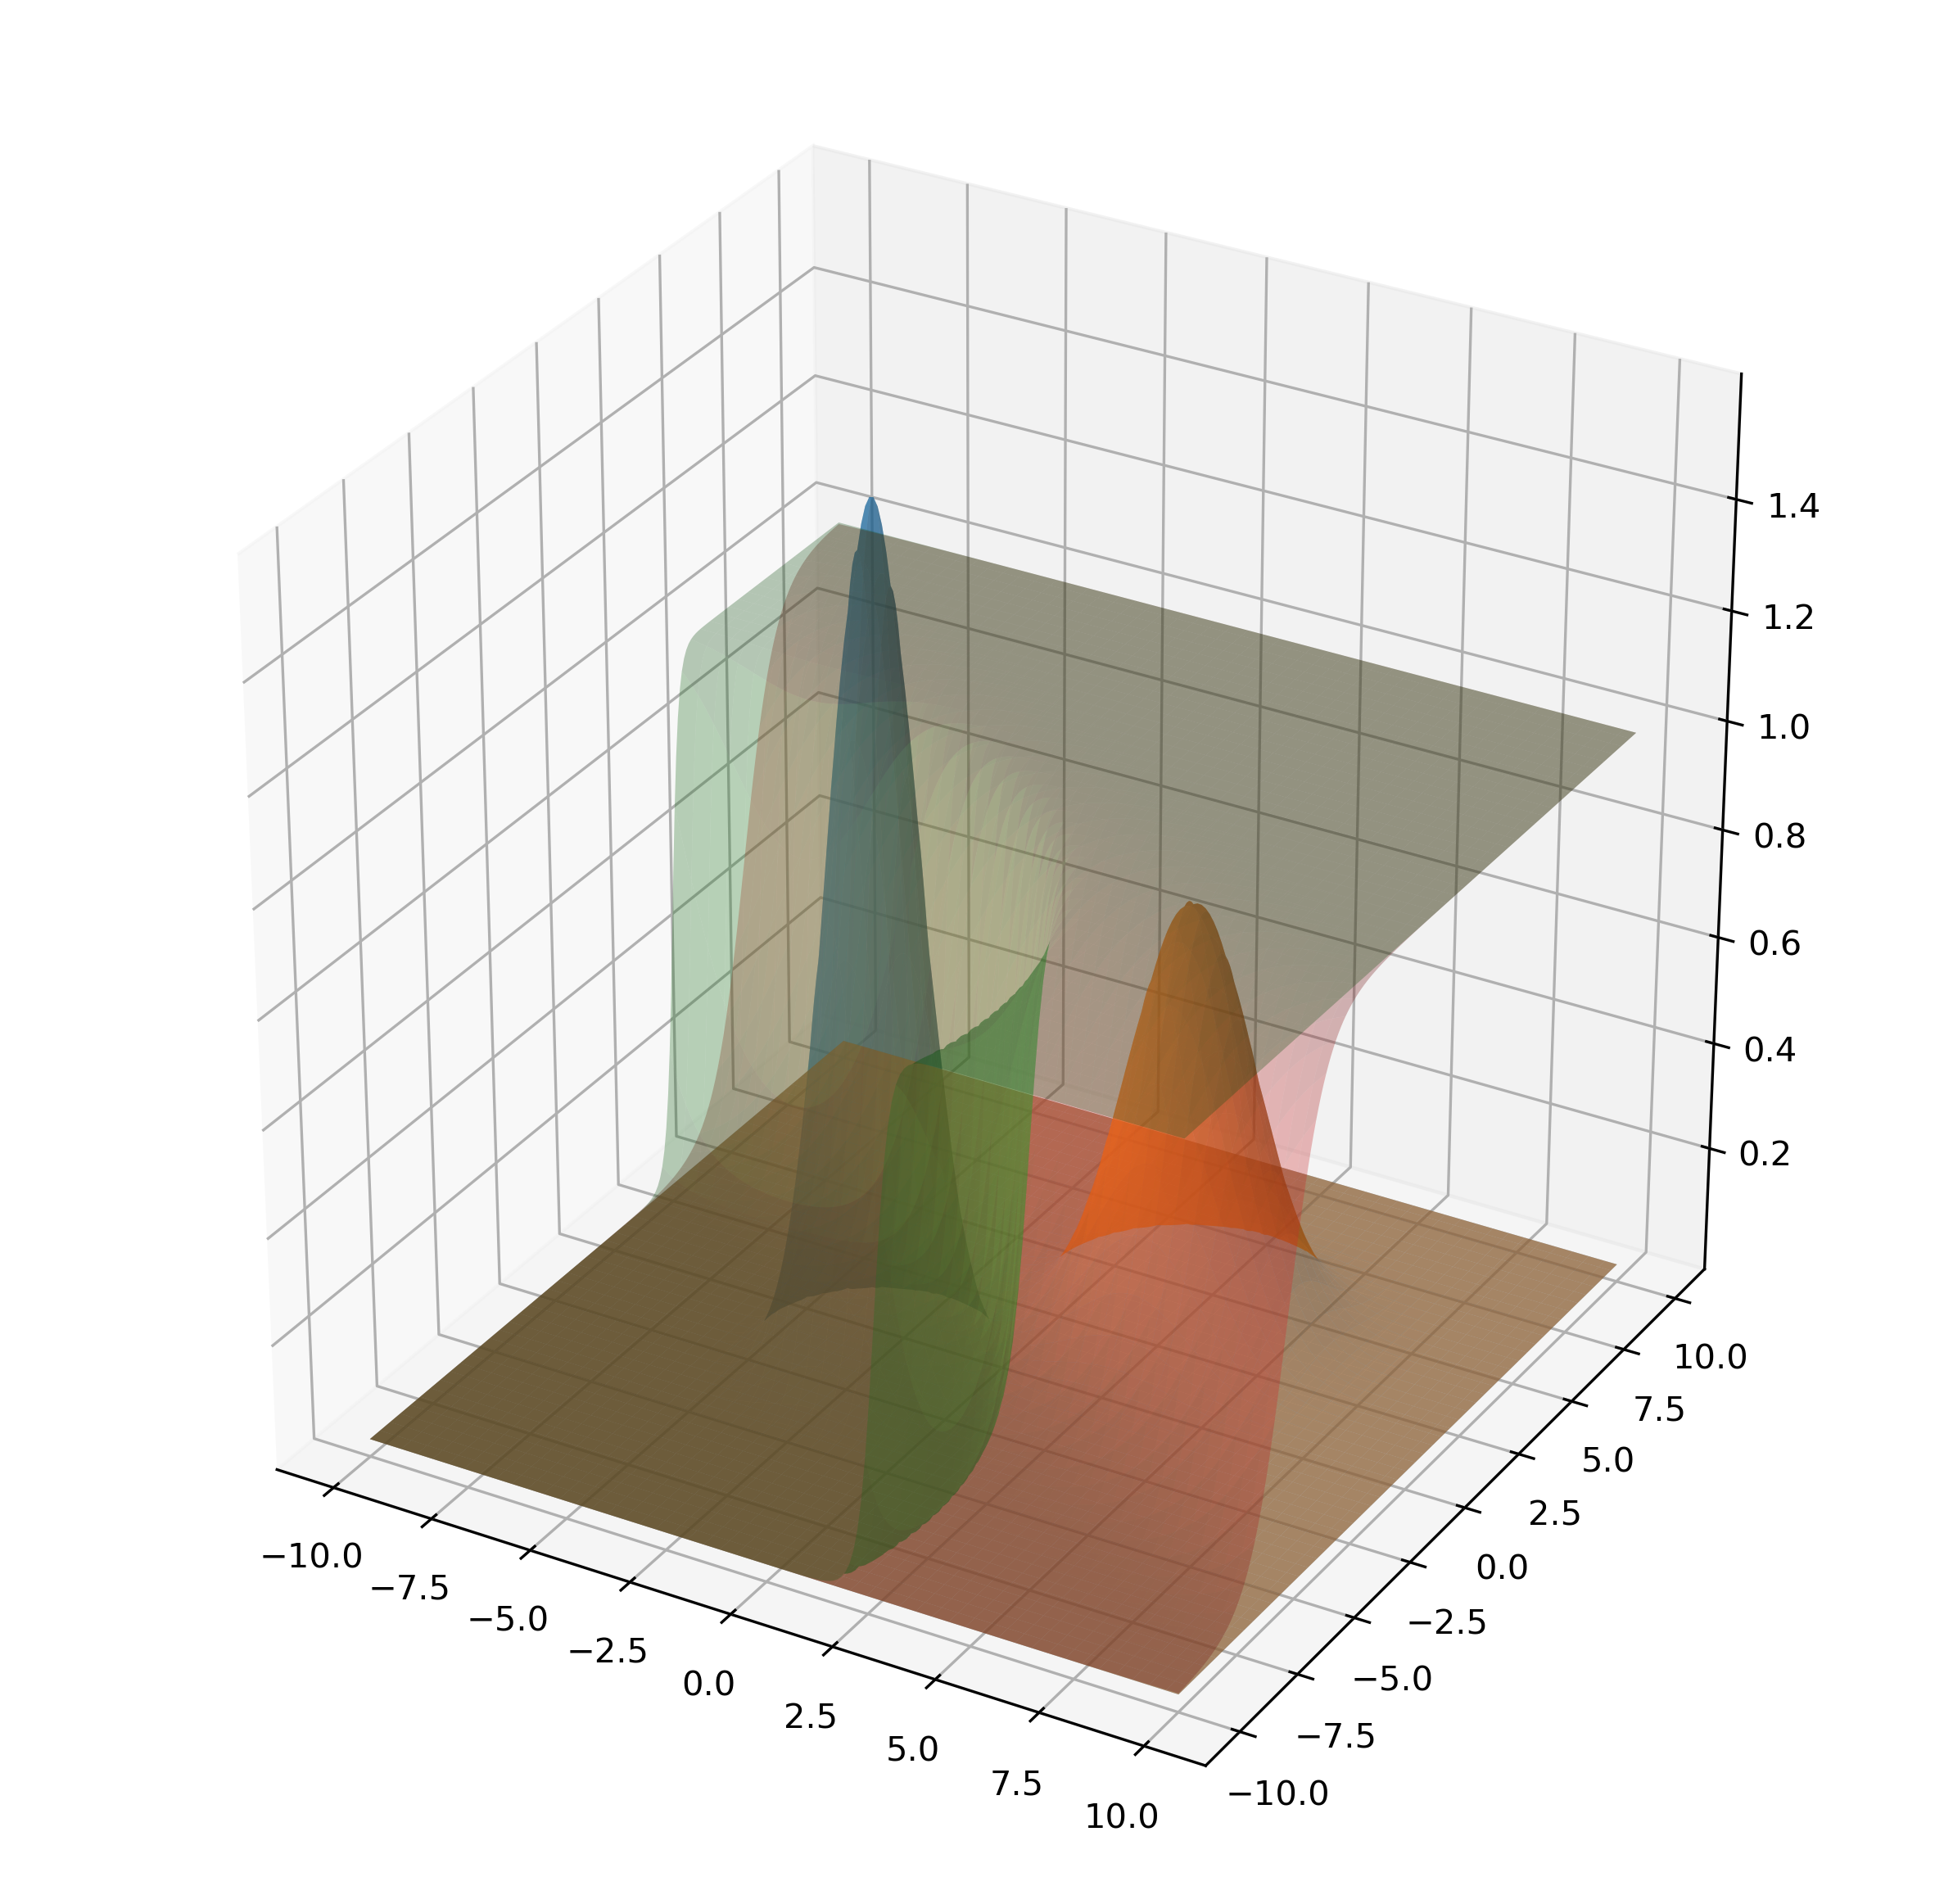

In [8]:
plotter = plt.figure(dpi = 300, figsize=(10,10))
gca = plotter.gca(projection='3d')
gca.plot_surface(X, Y, d0_pdf * 10, alpha = 0.5)
gca.plot_surface(X, Y, d1_pdf * 10, alpha = 0.5)
gca.plot_surface(X, Y, ratio, alpha = 0.3)
gca.plot_surface(X, Y, np.reshape(dist, (-1, len(x_scale))), alpha = 0.3)
plt.show()